<a href="https://colab.research.google.com/github/gurmaaan/MedNN/blob/master/Trained_CNN_no_changes_in_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подключение Google диска

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd /gdrive/My\ Drive/MedNN

/gdrive/My Drive/MedNN


In [0]:
#pytorch
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models

# general
import os
from collections import defaultdict
import time
import json
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score

## Загрузка данных 

In [0]:
#@title Параметры загрузчика

batch_size = 16  #@param {type: "slider", min: 4, max: 128}

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

resize_s = 256  #@param {type: "number"}
crop_s = 224  #@param {type: "number"}

train_path = "img/train" #@param ["img/train", "img/train_65", "img/train_enriched"] {allow-input: true}


In [0]:
def get_transforms(resize = 256, center_crop = 224):
    tr_dict = {
        'train': 
        [
            transforms.Resize(resize),
            transforms.CenterCrop(center_crop),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ],
        'valid': 
        [
            transforms.Resize(resize),
            transforms.CenterCrop(center_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ],
        'test': 
        [
            transforms.Resize(resize),
            transforms.CenterCrop(center_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]
    }
    return tr_dict

In [0]:
def update_data(path_dict, resize = 256, center_crop = 224, batch_size = 4):
    data_transforms = get_transforms(resize, center_crop)
    image_datasets = {x: ImageFolder(paths[x], transforms.Compose(data_transforms[x])) for x in paths}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in paths}
    return data_transforms, image_datasets, dataloaders

In [0]:
paths = {
    "train" : train_path,
    "test" : "img/test",
    "valid" : "img/valid"
}

In [0]:
data_transforms, image_datasets, dataloaders = update_data(paths, resize_s, crop_s, batch_size)

In [9]:
class_names = image_datasets['train'].classes
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

TODO: проверить как веса в data loader будут влиять на качество

In [0]:
# target = torch.tensor(image_datasets["train"].targets)
# class_sample_count = torch.tensor([(target == t).sum() for t in torch.unique(target, sorted=True)])
# weight = 1. / class_sample_count.float()
# samples_weight = torch.tensor([weight[t] for t in target])

# sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))
# dataloaders["train"] = DataLoader(image_datasets["train"], batch_size=batch_size, num_workers=4, sampler=sampler)

In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in paths}
dataset_sizes

{'test': 2504, 'train': 5633, 'valid': 1878}

In [12]:
class_counts = defaultdict(dict)
for p in paths:
    for cl in class_names:
        class_counts[p][cl] = len(os.listdir(f"{paths[p]}/{cl}"))
pd.DataFrame(class_counts)

,train,test,valid
actinic keratosis,71,30,29
basal cell carcinoma,297,127,90
dermatofibroma,65,28,22
melanoma,608,303,202
nevus,3760,1673,1272
pigmented benign keratosis,632,259,208
squamous cell carcinoma,120,47,30
vascular lesion,80,37,25


## Device

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("CPU device")

Tesla T4


## Визуализация 

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    
    #revert normalization
    inp = std * inp + mean
    
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

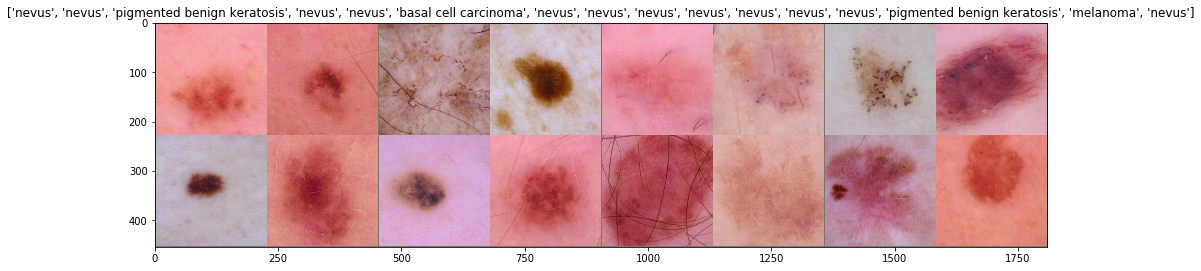

In [15]:
imgs, labels = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(imgs)

imshow(out, title=[class_names[x] for x in labels])

## Функция обучения


In [0]:
def train_model(model, criterion, optimizer, scheduler = None, num_epochs=25):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    stat_dict = {
        "train" :{ "epoch" : [], "loss" : [], "acc" : [] },
        "valid" :{ "epoch" : [], "loss" : [], "acc" : [] }
    }

    for epoch in range(num_epochs):
        estart_time = time.time()
        # У каждой эпохи есть фаза обучения и фаза валидации 
        for phase in ["train", "valid"]:
            is_train_phase = (phase == "train")
            # Ставим модель в нужный режим в зависимости от фазы 
            model.train(is_train_phase)
            running_loss = 0.0
            running_corrects = 0
            
            # Проходим по датасету партиями размером с батч
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Обнуляем градиенты вычесленные на предыдущем батче, иначе они будут складываться один за другим 
                optimizer.zero_grad()
                # Прямой проход Общая для обучения и валидации. 
                # Если фаза обучения, то все градиенты (частные производные функции потерь) 
                # будут вычислены чтобы вычесть их из текущих весов. Если валидация - вычисляться не будут
                with torch.set_grad_enabled(is_train_phase):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # Реализация обратного распространения ошибки 
                    if is_train_phase:
                        # Рассчет всех частных производных dloss_dw1(w1_0). Внутри батча усредняются
                        loss.backward()
                        # обновление весов (w1_1 = w1_0 - lr * dloss_dw1(w1_0) и так далее
                        optimizer.step() 

                # statistics inputs.size(0) = batch_size 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if is_train_phase and (scheduler is not None):
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            stat_dict[phase]["epoch"].append(epoch)
            stat_dict[phase]["loss"].append(epoch_loss)
            stat_dict[phase]["acc"].append(epoch_acc.item())
            
            te = time.time() - estart_time
            print(f"Эпоха {epoch + 1}/{num_epochs}. {phase}. loss: {epoch_loss : .4f}. acc: {epoch_acc : .4f}. Время {te // 60 : .0f}м {te % 60 : .0f}с")
                
            # deep copy the model
            if (not is_train_phase) and (epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - start_time
    print(f"Обучение закончено. Общее время: {time_elapsed // 60 : .0f}м {time_elapsed % 60 : .0f}с")
    print(f"Лучший valid acc: {best_acc : .4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, stat_dict

## Функция тестирования

In [0]:
def test_model(model, print_log=True):
    start_time = time.time()
    result_dict = { "real" : [], "predicted" : [] }

    with torch.no_grad():
        for images, labels in dataloaders["test"]:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                result_dict["real"].append(class_names[labels[i]])
                result_dict["predicted"].append(class_names[predicted[i]])

    result_df = pd.DataFrame(result_dict)

    acc_dict = {}
    total_acc = accuracy_score(result_df["real"], result_df["predicted"]) * 100
    acc_dict["total"] = total_acc

    for img_class in class_names:
        class_df = result_df[result_df["real"] == img_class]
        class_acc = accuracy_score(class_df["real"], class_df["predicted"]) * 100
        acc_dict[img_class] = class_acc
        if print_log:
            print(f"{img_class} ({len(class_df)}) : {class_acc : .2f}%")

    if print_log:
        print(f"Общий test acc: {total_acc : .2f}%")
        time_elapsed = time.time() - start_time
        print(f"Время тестирования: {time_elapsed // 60 : .0f}м {time_elapsed % 60 : .0f}с")
    
    return acc_dict

## Вспомогательные функции 

In [0]:
def convert_score_to_df(score_dict, save_flag=True, save_path = "/nn", save_dir="", single_model=False):
    data = defaultdict(list)
    if len(score_dict.keys()) > 0:
        first_model_name = list(score_dict.keys())[0]
        for scope in score_dict[first_model_name]:
            data["scope"].append(scope)
            for model_name in score_dict:
                data[model_name].append(f"{score_dict[model_name][scope] : .2f}")
        
        df = pd.DataFrame(data)
        df = df.set_index("scope")
        
        if save_flag:
            output_dir = f"{save_path}/{save_dir}"
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
            file_name = f"{first_model_name}_score.csv" if single_model else "models_score.csv"

            df.to_csv(f"{output_dir}/{file_name}", sep=';')
    else:
        df  = pd.DataFrame()
    return df

In [0]:
def save_learning_stat(loss_dict, save_path = "/nn", save_dir="", modelname="NN"):
    output_dir = f"{save_path}/{save_dir}"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    with open(f"{output_dir}/{modelname}.json", 'w') as json_file:
        json.dump(loss_dict, json_file)

In [0]:
def plot_learning_curve(data, model_name, save_flag=True, save_path = "/nn", save_dir=""):
    # data = json.load(open(path_json, 'r'))
    
    epochs = data["train"]["epoch"]
    
    fig, axs = plt.subplots(2, figsize=(16,12))
    # model_name = path.split('/')[-1].split('.')[0]
    fig.suptitle(model_name)
    
    epcnt = float(epochs[-1])
    step = 1
    while epcnt / step >= 20:
        step += 1

    for i, mode in enumerate(["loss", "acc"]):
        for phase in ["train", "valid"]:
            axs[i].set_title(mode)
            axs[i].plot(epochs, data[phase][mode], label=phase)
            axs[i].set_xlabel("Эпохи")
            axs[i].legend(loc=1)
            axs[i].grid(True)
            delta = 0.001
            axs[i].set_xlim(xmin=(0 - delta), xmax=(epcnt + delta))
            axs[i].set_xticks([xt for xt in range(0, int(epcnt+1), step)])

    if save_flag:
        output_dir = f"{save_path}/{save_dir}"
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        save_learning_stat(data, save_path, save_dir, model_name)
        plt.savefig(f"{output_dir}/{model_name}.png")

# **ОБУЧЕНИЕ**

In [0]:
#@title Параметры обучения

save_path = "/gdrive/My Drive/MedNN/nn" #@param {type: "string"}
save_dir = "deftBlnc_noSamplerWts" #@param {type: "string"}
#@markdown ---
num_epochs = 3 #@param {type:"slider", min:3, max:45, step:3}
#@markdown ---
start_lr = 0.01  #@param {type: "number"}
use_lr_scheduler = True #@param {type:"boolean"}
lr_scheduler_step = 2 #@param {type:"integer"}

In [0]:
def learn_model(model, model_name, params_to_learn):
    print('_' * 30, model_name, '_' * 30)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(params_to_learn, lr=start_lr, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=0.1) if use_lr_scheduler else None

    model, learning_dict = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)
    plot_learning_curve(learning_dict, model_name, True, save_path, save_dir)
    coeff_path = f"{save_path}/{save_dir}/{model_name}.pth"
    torch.save(model.state_dict(), coeff_path)
    print('-' * 80)
    score = test_model(model, False)
    return convert_score_to_df({model_name : score}, True, save_path, save_dir, True)
    # return model

**ResNet**

Первая эпоха очеьн долгая, дальше нормально. Но если заморозить все веса, то все быстро да и точность выше

In [0]:
model_name = "ResNet_152"
model = models.resnet152(pretrained=True)
# fc

In [0]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

learn_model(model, model_name, model.fc.parameters())

**Inception_v3**

Очень долго качает коэффициенты

In [0]:
model_name = "Inception_v3"
model = models.inception_v3(pretrained=True)
# fc

In [0]:
data_transforms, image_datasets, dataloaders = update_data(resize=340, center_crop=299, batch_size)

model.aux_logits=False

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

learn_model(model, model_name, model.fc.parameters())

**AlexNet**

In [0]:
model_name = "AlexNet"
model = models.alexnet(pretrained=True)
# classifier

In [0]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_names))

learn_model(model, model_name, model.classifier[-1].parameters())

**VGG**

In [0]:
model_name = "VGG_19_bn"
model = models.vgg19_bn(pretrained=True)
# classifier

In [0]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_names))

learn_model(model, model_name, model.classifier[-1].parameters())

**ShuffleNet**

In [0]:
model_name = "ShuffleNet_v2_x1-0"
model = models.shufflenet_v2_x1_0(pretrained=True)
# fc

In [0]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# for p in model.parameters():
#     if p.requires_grad:
#         print(p)
learn_model(model, model_name, model.parameters())

**MobileNet**

In [0]:
model_name = "MobileNet_v2"
model = models.mobilenet_v2(pretrained=True)
# classifier

**MnasNet**

In [0]:
model_name = "MnasNet_1-0"
model = models.mnasnet1_0(pretrained=True)
# classifier

**ResNeXt**

In [0]:
model_name = "ResNeXt_101_32x8d"
model = models.resnext101_32x8d(pretrained=True)
# fc

In [0]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

learn_model(model, model_name, model.fc.parameters())

**Wide_ResNet**

In [0]:
model_name = "Wide_ResNet_101-2"
model = models.wide_resnet101_2(pretrained=True)
# fc

## Предсказание

In [0]:
def predict(img_path=None, model_name="inception_v3", path="/nn/default/inception_v3.pth"):
    if os.path.isfile(img_path) and (model_name in model_dict) and os.path.isfile(img_path):
        img = Image.open(img_path)
        model = model_dict[model_name]
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 8)
        model.load_state_dict(torch.load(path))
        model.eval()
        
        img_input = transforms.Compose(data_transforms["test"])(img)
        img_input = img_input.unsqueeze(0)
        with torch.no_grad():
            output = model(img_input)
            _, predicted = torch.max(output.data, 1)
            proba = torch.nn.functional.softmax(output, dim=1).tolist()[0]
            
            plt.barh(class_names, proba, align="center")
            plt.xlim(0, 1)
            plt.xticks(np.arange(0, 1, 0.1))
            plt.grid(True, axis="x")
            
            for i, p in enumerate(proba):
                print(f"{p : .10f} - {class_names[i]}")
                plt.text(p, i, f"{p : .10f}")
        return class_names[predicted[0]]
    else:
        return None